In [1]:
import os
import pandas as pd

# 불필요한 경고 표시 생략
import warnings
warnings.filterwarnings(action = 'ignore')

a=%pwd # 현재 경로 a에 할당
os.chdir(a) # 파일 로드 경로 설정

- 아파트 가격 예측 등 '지역' 이 포함되는 데이터 분석에서 주소나 위치 변수 등을 기준으로 `거리가 가까운 레코드 및 관련 통계치` 를 통합해야 하는 경우가 있다.


- 이를 통합하는 방법은 보통 3단계를 거친다.
---
1) 각 데이터에 포함된 레코드 간 거리를 나타내는 `거리 행렬을 생성`


2) 거리 행렬의 행 or 열 기준 `최소 값을 가지는 인덱스` 를 바탕으로 `이웃한 데이터 탐색`


3) 탐색한 `이웃 데이터` 를 기존 데이터에 부착

![거리데이터](이미지13.png)

- 서로 다른 주소값을 가진 2개의 데이터 테이블이 있다. (원본데이터의 주소값= A, B, C)
- 이때 각각 주소 A, B, C에 대응하는 주소 X, Y, Z간의 거리를 계산하는 `거리행렬`을 생성한다.
- 각각의 주소 A, B, C와 가장 인접한 `이웃 데이터` 를 탐색한 뒤, 해당 데이터를 원본데이터에 붙여넣는다.

# 관련 문법 1 : scipy.spatial.distance.cdist
---

- 두개의 행렬을 바탕으로 `거리행렬`을 반환하는 함수
- 일반적인 머신러닝 모델을 만들때, opensource로 된 데이터를 쓰지 않고 실용적인 데이터를 만들때 많이 사용된다.(특히 KNN)
- 데이터가 scipy함수에 사용할 수 있는 `연속형 변수` 이어야만 사용할 수 있다.


주요 파라미터

---
- XA : 거리 행렬 계산 대상인 행렬 (ndarray / DataFrame), `함수의 출력 행` 이다.
- XB : 거리 행렬 계산 대상인 행렬 (ndarray / DataFrame), `함수의 출력 열` 이다.
- metric : 거리 척도 방식 선택 ('cityblock', 'correlation', 'cosine', 'educlidean', 'jaccard', 'matching' 등)
---

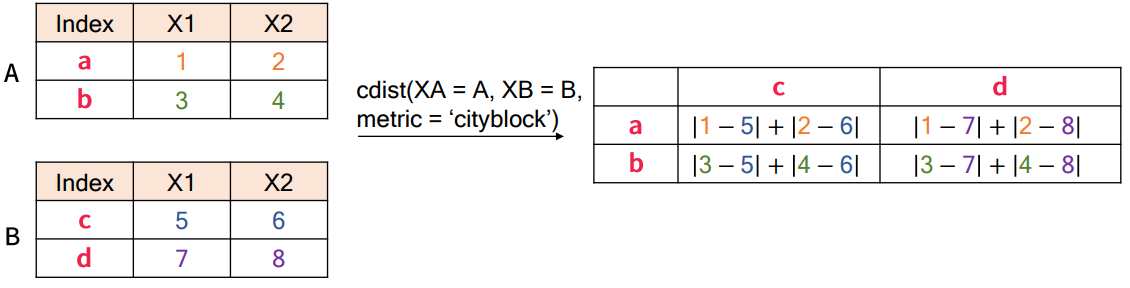

# 관련 문법 2 : ndarray.argsort
---

- 작은 값부터 순서대로 데이터의 `위치(index)를 반환하는 함수`이다. 즉, 각 순위를 매기고 최소값을 갖게 만든 index가 무엇인지 찾게 해주는 함수
- 주로 `이웃을 찾을 때` 많이 활용된다.
- axis = 0 이면 `열 별 위치`, axis = 1 이면 `행 별 위치` 를 return
- Tip. 하나의 값만을 찾는것이 목적이라면 DataFrame의 idxmax(), idxmin() 함수를 사용하는 것이 더 유용하다.

[idxmax() document](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.idxmax.html)


[idxmin() document](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.idxmin.html)

---

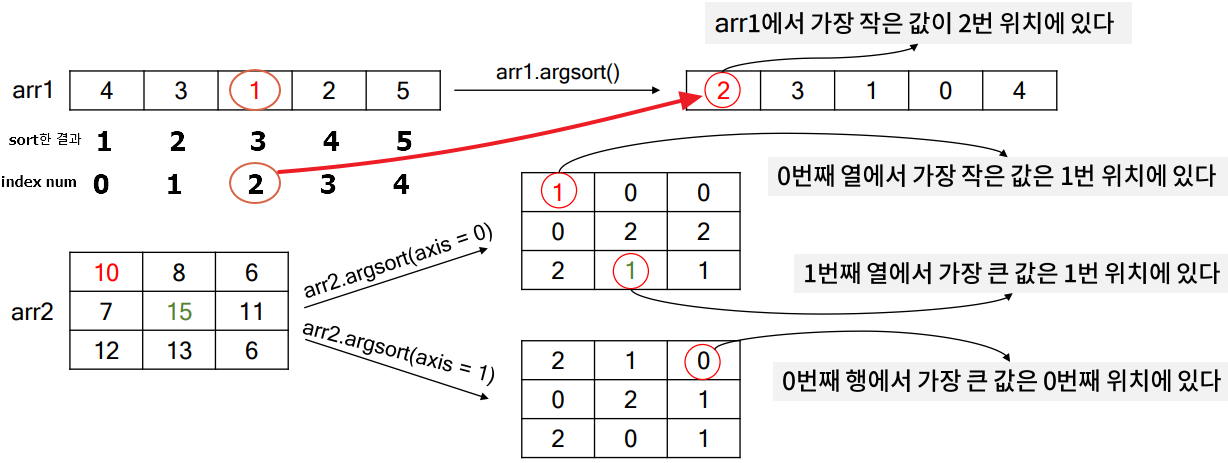

- arr1 (1차원) 의 경우 axis 파라미터가 적용되지 않는다.
- arr2 (2차원) 의 경우 axis=0일때, 첫번째 열인 10, 7, 12를 예시로 보면 세 개의 수를 정렬하면 7 < 10 < 12가 된다.
- 기존 7의 index값은 1이 argsort(axis=0)의 결과로 출력된다.
- 나머지도 동일한 방식으로 적용되어 우측의 결과값으로 나타난다.

# 거리기반 데이터 병합 실습

2019년 서울 아파트 거래가 & 주소 데이터에 지하철 역 별 위도 / 경도 데이터를 활용해서 `가장 가까운 역이 어디인지` 파악

In [2]:
# 아파트 관련 데이터 불러오기 
# 한글 자료이므로, 글씨 깨짐 방지위해 cp949로 encoding 한다.

df1 = pd.read_csv("2019년_서울_아파트매매_실거래가.csv", encoding = "cp949")
df2 = pd.read_csv("2019년_서울시_아파트주소.csv", encoding = "cp949")

In [3]:
df1.head()

,거래일자,법정동,도로명,아파트,층,전용면적,건축년도,거래금액
0,2019-10-05,면목동,용마산로,현대,2,84.81,1994,52000
1,2019-10-07,면목동,중랑천로,신성,5,59.91,1998,37000
2,2019-10-09,면목동,용마산로,현대,19,84.09,1994,57500
3,2019-10-10,면목동,사가정로41길,동원베네스트,5,84.86,2003,56000
4,2019-10-14,면목동,용마산로,현대,9,72.63,1994,50500


In [4]:
df2.head()

,시군구명,읍면동명,도로명,건물명,경도,위도
0,종로구,신교동,필운대로,월드빌,126.966744,37.586644
1,종로구,숭인동,숭인동1길,삼성타운,127.017780,37.579576
2,종로구,숭인동,숭인동1나길,삼성타운,127.018026,37.579582
3,종로구,평창동,평창6길,월드빌,126.973484,37.620055
4,중구,장충동1가,장충단로6가길,삼우빌라,127.006113,37.563739


## step1. 두개의 데이터를 이어 붙인다.

In [5]:
# 데이터 병합
# 병합될 컬럼의 순서가 일치해야 merge()가 적용된다. 
# 법정동 = 읍면동 // 도로명 = 도로명 // 아파트 = 건물명 으로 각각 붙여주는 것

df = pd.merge(df1, df2,left_on = ['법정동', '도로명', '아파트'], right_on = ['읍면동명', '도로명', '건물명'])
df

,거래일자,법정동,도로명,아파트,층,전용면적,건축년도,거래금액,시군구명,읍면동명,건물명,경도,위도
0,2019-10-23,면목동,겸재로,동서그랜드맨션,4,131.34,1993,43000,중랑구,면목동,동서그랜드맨션,127.075856,37.588817
1,2019-10-25,면목동,면목로,킴스아파트,4,38.91,2018,28900,중랑구,면목동,킴스아파트,127.084734,37.592972
2,2019-10-29,면목동,용마산로86길,면목동2차미소지움아파트,12,78.56,2005,45400,중랑구,면목동,면목동2차미소지움아파트,127.094170,37.589641
3,2019-12-04,면목동,용마산로86길,면목동2차미소지움아파트,4,81.96,2005,45500,중랑구,면목동,면목동2차미소지움아파트,127.094170,37.589641
4,2019-12-26,면목동,용마산로86길,면목동2차미소지움아파트,3,82.28,2005,45500,중랑구,면목동,면목동2차미소지움아파트,127.094170,37.589641
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1478,2019-11-11,망원동,방울내로11길,동보프리미아,9,63.02,2004,39000,마포구,망원동,동보프리미아,126.894313,37.562626
1479,2019-12-04,신공덕동,백범로,신공덕e편한세상,2,59.62,2007,89900,마포구,신공덕동,신공덕e편한세상,126.954378,37.544351
1480,2019-12-07,신공덕동,백범로,신공덕e편한세상,4,59.58,2007,92500,마포구,신공덕동,신공덕e편한세상,126.954378,37.544351
1481,2019-12-16,신공덕동,백범로,신공덕e편한세상,11,59.85,2007,100000,마포구,신공덕동,신공덕e편한세상,126.954378,37.544351


문제 상황인 `가장 가까운 지하철역` 을 찾기위해 위치 계산을 할 대상 데이터를 불러온다.

In [6]:
df3 = pd.read_excel("지하철역_위경도.xlsx")

In [7]:
df3.head()

,역명,위도,경도
0,가양역[9호선],37.561560,126.854261
1,완정역[2호선],37.592867,126.673027
2,증미역[9호선],37.558144,126.860617
3,마전역[2호선],37.597649,126.667201
4,등촌역[9호선],37.550694,126.865540


## step2. 거리 행렬 계산 (scipy.spatial.distance import cdist)

In [8]:
# !pip install haversine# 위경도 거리 계산을 위한 모듈 설치(필요시 설치)

In [9]:
# 거리 행렬 생성을 위한 컬럼 추출
 
df_location = df[['경도', '위도']]

df3_location = df3[['경도', '위도']]

#지구상의 위경도 거리를 구할때는 유클리드 거리나 보스턴 거리사용보다는 haversine거리를 사용하는게 일반적

In [10]:
# 거리 행렬 생성
from scipy.spatial.distance import cdist
from haversine import haversine

#cdist(행, 열)함수를 사용해 거리를 계산
# metric= 에 들어갈 수 있는 것들 :  ['euclidean', 'cityblock', 'jaccard'] (기본적으로 내장된 것들)
# 또는 haversine 처럼 외부 패키지를 설치하고 사용할 수도 있다.

dist_mat = cdist(df_location, df3_location, metric = haversine)

## step3. argsort()를 적용해 이웃 지역 탐색후 병합

In [11]:
# close_subway_index = dist_mat.argsort()는 실제 위치에 대한 단순한 정보만을 가져온 것이다.
# close_subway_index = dist_mat.argsort()에 [:, 0]으로 가장 첫번째(가장 거리가 짧은 = 가까운) 지하철의 index값을 불러온다.

close_subway_index = dist_mat.argsort()[:, 0] # axis = 0

# '가까운역' 이라는 컬럼을 새로 추가하고 그 변수에 새로운 값을 입력한다.
#  df3.iloc[close_subway_index]['역명'] 까지만 입력하면 인덱스간 충돌이 발생할 수 있다.(scipy함수의 결과값은 ndarray)
# 그래 .value를 붙여서 값을 가져 오라고 명시
df['가까운역'] = df3.iloc[close_subway_index]['역명'].values 

# 새로운 시리즈를 만들 때는 list, ndarray를 사용하는 것이 바람직하다!

df['가까운역까지_거리'] = dist_mat[close_subway_index][:, 0]

In [12]:
df.head()

,거래일자,법정동,도로명,아파트,층,전용면적,건축년도,거래금액,시군구명,읍면동명,건물명,경도,위도,가까운역,가까운역까지_거리
0,2019-10-23,면목동,겸재로,동서그랜드맨션,4,131.34,1993,43000,중랑구,면목동,동서그랜드맨션,127.075856,37.588817,중랑역[경춘선],22.308503
1,2019-10-25,면목동,면목로,킴스아파트,4,38.91,2018,28900,중랑구,면목동,킴스아파트,127.084734,37.592972,상봉역[7호선],25.366110
2,2019-10-29,면목동,용마산로86길,면목동2차미소지움아파트,12,78.56,2005,45400,중랑구,면목동,면목동2차미소지움아파트,127.094170,37.589641,망우역[경의중앙선],25.379852
3,2019-12-04,면목동,용마산로86길,면목동2차미소지움아파트,4,81.96,2005,45500,중랑구,면목동,면목동2차미소지움아파트,127.094170,37.589641,망우역[경의중앙선],25.379852
4,2019-12-26,면목동,용마산로86길,면목동2차미소지움아파트,3,82.28,2005,45500,중랑구,면목동,면목동2차미소지움아파트,127.094170,37.589641,망우역[경의중앙선],25.379852
